# Traffic Sign Recognition Classifier

## Project within the Self-Driving Car Engineer Nanodegree: Deep Learning


The template for this project can be found at [Udacity's github account](https://github.com/udacity/CarND-Traffic-Sign-Classifier-Project). The [data](https://d17h27t6h515a5.cloudfront.net/topher/2017/February/5898cd6f_traffic-signs-data/traffic-signs-data.zip) used in this project is a pre-processed version of the [German Traffic Sign Dataset](http://benchmark.ini.rub.de/?section=gtsrb&subsection=dataset). The project full-fills all points of the project's [rubric](https://review.udacity.com/#!/rubrics/481/view) and includes also some of the stand-out suggestions.

This notebook is a modified version of the above template.

---
## Step 0: Load The Data

In [1]:
# Load some basic libraries
import numpy as np # Efficient numerical arrays
import pandas as pd # Time series analysis
import matplotlib.pyplot as plt # Visulisation
from IPython.display import display # Nicer visulisation of dataframes
import random
import cv2
import tensorflow as tf

#IPython line magic
%matplotlib inline

# Syntax sensitive versions
print('Version')
print('-------')
print('Tensorflow: \t' + tf.__version__)
print('OpenCV: \t' + cv2.__version__)
print('Pandas: \t' + pd.__version__)

# For tensorflow with gpu support: Check if GPU is found (from console)
#sess = tf.Session(config=tf.ConfigProto(log_device_placement=True))

Version
-------
Tensorflow: 	1.4.0
OpenCV: 	3.3.0
Pandas: 	0.21.0


In [2]:
# Load pickled data
import pickle

training_file = "../train.p"
validation_file = "../valid.p"
testing_file = "../test.p"
signnames_file = "signnames.csv"

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(validation_file, mode='rb') as f:
    valid = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)

signnames = pd.read_csv(signnames_file)
    
X_train, y_train = train['features'], train['labels']
X_valid, y_valid = valid['features'], valid['labels']
X_test, y_test = test['features'], test['labels']

---

## Step 1: Dataset Summary & Exploration

The pickled data is a dictionary with 4 key/value pairs:

- `'features'` is a 4D array containing raw pixel data of the traffic sign images, (num examples, width, height, channels).
- `'labels'` is a 1D array containing the label/class id of the traffic sign. The file `signnames.csv` contains id -> name mappings for each id.
- `'sizes'` is a list containing tuples, (width, height) representing the original width and height the image.
- `'coords'` is a list containing tuples, (x1, y1, x2, y2) representing coordinates of a bounding box around the sign in the image. **THESE COORDINATES ASSUME THE ORIGINAL IMAGE. THE PICKLED DATA CONTAINS RESIZED VERSIONS (32 by 32) OF THESE IMAGES** 

### Basic Summary of the Data Set

In [3]:
n_train = X_train.shape[0]
n_validation = X_valid.shape[0]
n_test = X_test.shape[0]

# shape of an traffic sign image
image_shape = X_train.shape[1:]

# unique classes/labels
n_classes = len(np.unique(y_train))

print("Number of training examples =", n_train)
print("Number of validation examples =", n_validation)
print("Number of testing examples =", n_test)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)

Number of training examples = 34799
Number of validation examples = 4410
Number of testing examples = 12630
Image data shape = (32, 32, 3)
Number of classes = 43


### Visualization of the German traffic sign dataset

First of all, a visualisation of randomly sampled data gives a feeling for the data set in general. Visual inspection of the traffic sign shows that
- mosts signs are well centered with some padding around
- only the colors white, black, red, blue and yellow play a role
- the data set contains various brightness and saturation levels of the images
- most images are frontal, but few are also "perspective"

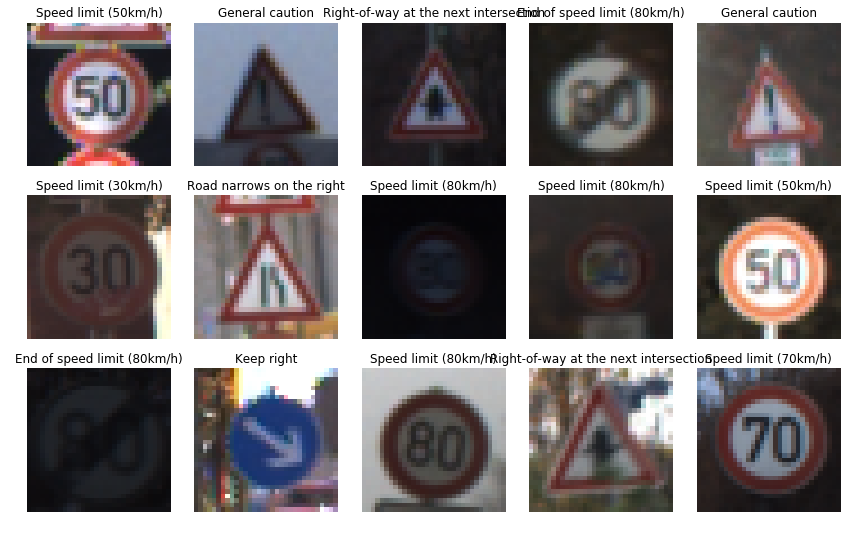

In [4]:
def signname(index, y_data=y_train):
    return signnames['SignName'].values[y_data[index]]
    #return signnames.loc[y_data[index]]['SignName']

def signname_label(label):
    return signnames['SignName'].values[label]    
    
def plot_training_image(index):
    plt.figure()
    #label = signnames
    plt.title('Label: {}'.format(signname(index)))
    plt.imshow(X_train[index])
    plt.show()

# Plot some examples
fig, axs = plt.subplots(3,5, figsize=(15, 9))
fig.subplots_adjust(hspace = .2, wspace=.001)
axs = axs.ravel()
for i in range(15):
    index = random.randint(0, len(X_train))
    axs[i].set_title('{}'.format(signname(index)))
    axs[i].axis('off')
    axs[i].imshow(X_train[index])

#### Distribution of classes in the data set
Analysing the distibution of the training, validation and test set can give information about possible biases which might occure during training of the model. Hence the following histogramms are a good starting point for choosing the right preprocessing steps.

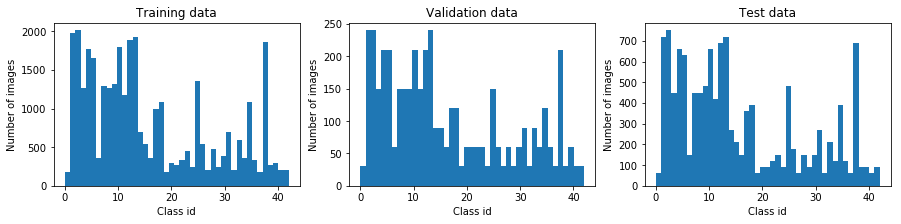

In [5]:
fig, axs = plt.subplots(1,3, figsize=(15,3))
n, bins, patches = axs[0].hist(y_train, bins=n_classes)
axs[0].set_title('Training data')
axs[0].set_xlabel('Class id')
axs[0].set_ylabel('Number of images')

axs[1].hist(y_valid, bins=n_classes)
axs[1].set_title('Validation data')
axs[1].set_xlabel('Class id')
axs[1].set_ylabel('Number of images')

axs[2].hist(y_test, bins=n_classes)
axs[2].set_title('Test data')
axs[2].set_xlabel('Class id')
axs[2].set_ylabel('Number of images')

plt.show()

The file `signnames.csv` contains the mapping of the traffic sign name to its label (called class id). The file is read in as a `pandas.DataFrame` and can be easily enhanced with columns stating the frequency of a label. Below is a print-out of the whole DataFrame order by the frequency i.a. the upper most traffic sign is the most common traffic sign in the data set.

In [6]:
# Add the values to the signnames dataframe to do more stuff
signnames['Amount'] = n
signnames['Percentage'] = n / n_train * 100

# ToDo rename the variables as signnames will change the index
sorted_signnames = signnames.sort_values(by=['Percentage'], ascending=False)
# To make sure that the referencing works fine, sort by class_id (--> index=class_id)
signnames.sort_values(by=['ClassId'], inplace=True)

display(sorted_signnames)

,ClassId,SignName,Amount,Percentage
2,2,Speed limit (50km/h),2010.0,5.776028
1,1,Speed limit (30km/h),1980.0,5.689819
13,13,Yield,1920.0,5.517400
12,12,Priority road,1890.0,5.431191
38,38,Keep right,1860.0,5.344981
10,10,No passing for vehicles over 3.5 metric tons,1800.0,5.172562
4,4,Speed limit (70km/h),1770.0,5.086353
5,5,Speed limit (80km/h),1650.0,4.741516
25,25,Road work,1350.0,3.879422
9,9,No passing,1320.0,3.793212


#### Colour Channels
The images are RGB images. For deep learning this will be always a trade-off between additional information and parameter size. Below the colour channels of a test image is shown and its grey scale version. The blue channel is clearly different from the red and green one. As discussed above the colour channel could improve the model e.g. by thresholding for red and blue but for now only grey scale images are used to reduce dimensionality.

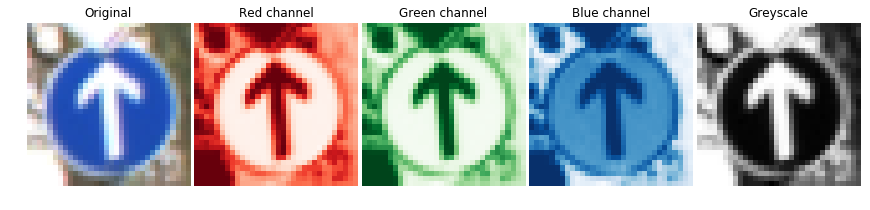

In [7]:
testimg = X_train[20000]

# Colour thresholding
#blue = testimg[:,:,2]
#blue = blue[blue>200]

testimg_G = cv2.cvtColor(testimg, cv2.COLOR_RGB2GRAY)

fig, axs = plt.subplots(1,5, figsize=(15, 3))
fig.subplots_adjust(hspace = .2, wspace=.001)
axs = axs.ravel()
axs[0].set_title('Original')
axs[0].imshow(testimg)
axs[1].set_title('Red channel')
axs[1].imshow(testimg[:,:,0], cmap='Reds')#, vmin=50, vmax=128)
axs[2].set_title('Green channel')
axs[2].imshow(testimg[:,:,1], cmap='Greens')#, vmin=50, vmax=128)
axs[3].set_title('Blue channel')
axs[3].imshow(testimg[:,:,2], cmap='Blues')#, vmin=50, vmax=128)
axs[4].set_title('Greyscale')
axs[4].imshow(testimg_G, cmap='Greys_r')
for i in range(5):
    axs[i].axis('off')

----

## Step 2: Design and Test a Model Architecture

The LeNet-5 implementation is a good starting point. The model can then be further improved considering the fellowing aspects
- Neural network architecture (is the network over or underfitting?)
- Play around preprocessing techniques (normalization, rgb to grayscale, etc)
- Number of examples per label (some have more than others).
- Generate fake data.

In this [published baseline model on this problem](http://yann.lecun.com/exdb/publis/pdf/sermanet-ijcnn-11.pdf), the authors Sermanet and LeCun suggest an approach which reached almost 99% accuracy. 

### 1. Augment the training data (generation of additional data)
The dataset was augmentated by randomly modified copies of the original images. The `tensorflow.image` module offers already several functions for data augmentation:
- random saturation
- random contrast
- random brightness
- random crop (not applicable, without resizing separately)

I used a combination of all functions to augement the data set. In the following is the result for a test image.

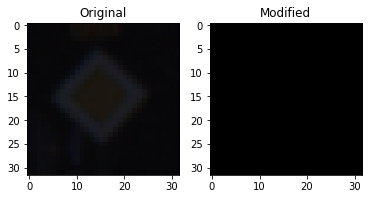

In [8]:
new_img = X_train[0]

def random_modification(image):
    new_img = image
    new_img = tf.image.random_saturation(image=new_img, lower=0.5, upper=1.5)
    new_img = tf.image.random_contrast(image=new_img, lower=0.5, upper=1.5)
    new_img = tf.image.random_brightness(image=new_img, max_delta=0.25)
    new_img = tf.random_crop(new_img, [32, 32, 3])
    #crop = np.random.uniform(0.75,1.0)
    #new_img = tf.image.central_crop(image=new_img, central_fraction=crop)
    #print(new_img.get_shape)
    #new_img = tf.image.resize_images(images=new_img, size=[32,32]) # seems to work wrong
    return new_img

# Would be better to use tensorflow dataset or queues but I don't know yet how they work
# Also you placeholders rather than a loop

sess = tf.Session()
with sess.as_default():
    random_idx = np.random.choice(len(X_train), 1)[0]
    array = random_modification(X_train[random_idx]).eval()
    #print(array.shape)
    #array = cv2.resize(array, (32,32)) # make sure it has the right size as tf.resize seems to screw up the colours
    
fig, ax = plt.subplots(1,2)
ax = ax.ravel()
ax[0].set_title('Original')
ax[0].imshow(X_train[random_idx])
ax[1].set_title('Modified')
ax[1].imshow(array)

Every label was augemented by at least 10 images until the label contained at least 500 images.
After augementaion, the training data contained ... images. The labels are distributed more equally now.

In [9]:
min_images = 500 # desired (minimal) amount of images
min_sample_size = 10 # Modify all classes to not introduce a bias
X_new = []
y_new = []

sess = tf.Session()
with sess.as_default():
    for label in range(n_classes):
        member = y_train == label
        X_oneclass = X_train[member,] # All data which has label 'i'
        sample_size = min_images - len(X_oneclass)
        if sample_size <= 0:
            sample_size = min_sample_size
        for new_count in range(sample_size):
            img = random.choice(X_oneclass) # randomly pick an image of that separated clas
            img_mod = random_modification(img).eval()
            X_new.append(img)
            y_new.append(i)
        print('Label {} was augmented with {} images'.format(label, sample_size))

X_new = np.array(X_new)
y_new = np.array(y_new)

X_train = np.concatenate([X_train, X_new])
y_train = np.concatenate([y_train, y_new])

assert X_new.shape[0] == y_new.shape[0], 'New Image and label set have different sizes'
assert X_train.shape[0] == y_train.shape[0], 'Image and label set have different sizes'

#from sklearn.utils import shuffle
#X_train, y_train = shuffle(X_train, y_train)

print('The training data contains now {} images'.format(len(X_train)))

Label 0 was augmented with 10 images
Label 1 was augmented with 10 images
Label 2 was augmented with 10 images
Label 3 was augmented with 10 images
Label 4 was augmented with 10 images
Label 5 was augmented with 10 images
Label 6 was augmented with 10 images
Label 7 was augmented with 10 images
Label 8 was augmented with 10 images
Label 9 was augmented with 10 images
Label 10 was augmented with 10 images
Label 11 was augmented with 10 images
Label 12 was augmented with 10 images
Label 13 was augmented with 10 images
Label 14 was augmented with 10 images
Label 15 was augmented with 10 images
Label 16 was augmented with 10 images
Label 17 was augmented with 10 images
Label 18 was augmented with 10 images
Label 19 was augmented with 10 images
Label 20 was augmented with 10 images
Label 21 was augmented with 10 images
Label 22 was augmented with 10 images
Label 23 was augmented with 10 images
Label 24 was augmented with 10 images
Label 25 was augmented with 10 images
Label 26 was augmented

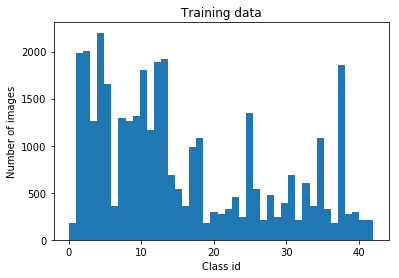

In [10]:
#Fast visualisation of new label distribution
fig, ax = plt.subplots()
n, bins, patches = ax.hist(y_train, bins=n_classes)
ax.set_title('Training data')
ax.set_xlabel('Class id')
ax.set_ylabel('Number of images')

### 2. Pre-process the Data Set (normalization, grayscale, etc.)

The image were converted to grayscale and then normalized using
`(data - np.array(data).mean()) / np.array(data).std()`

I used grayscaling to reduce the dimensionality of the data. However I considered adding the red and blue channels after thresholding since the traffic signs consist mainly of the colours black, white, red and blue.
The normalization is necessary so that the weights can be similar for every image and that the model does not get biased towards particularly "bright" images.

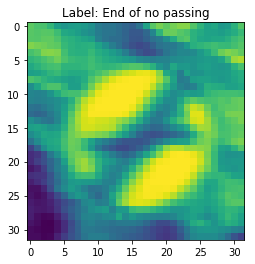

In [11]:
# Normalization
def Normalization(data):
    return (data - 128) / 128

def MinMaxScaler( data, max=255, min=0): #Images values have range 0-255
    return (data - min) / (max - min)

# Standardization
def Standardiser(data):
    return (data - np.array(data).mean()) / np.array(data).std()

# Data stretching = cutoff of noise/outliers
def Stretching(data):
    raise NotImplemented

# Colour Transformations
def Grayscale(data):
    data_new = []
    for i in range(len(data)):
         data_new.append(cv2.cvtColor( data[i], cv2.COLOR_RGB2GRAY))
    data_new = np.array(data_new)
    data_new.reshape(-1,32,32,1)
    return data_new

def ColourThreshold(data):
    ''' For colour (rgb) images only '''
    raise NotImplemented
    # Idea... add another layer e.g. red, green, blue and grayscale
    # Red and blue should be strongly thresholded since traffic signs are mainly these colours

# Combined pipleine for pre-processing
def preprocessing(data):
    data = Grayscale(data)
    #data = Normalization(data)
    #data = MinMaxScaler(data)
    data = Standardiser(data)
    return data

X_train = preprocessing(X_train)
X_valid = preprocessing(X_valid)
X_test = preprocessing(X_test)

In [12]:
# Check the shape of the input after preprocessing
print(X_train.shape)

try:
    input_depth = X_train.shape[3]
except:
    print('Preprocessing resulted in incompatible data format')

    try:
        X_train = X_train.reshape(len(X_train),32,32,1)
        input_depth = X_train.shape[3]
        
        X_valid = X_valid.reshape(len(X_valid),32,32,1)
        X_test = X_test.reshape(len(X_test),32,32,1)
        print('Succesfully reshaped to {}'.format(X_train.shape))
    except:
        pass

(35229, 32, 32)
Preprocessing resulted in incompatible data format
Succesfully reshaped to (35229, 32, 32, 1)


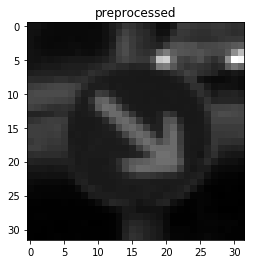

In [30]:
idx=50
plt.figure()
#plt.title('Label: {}'.format(signname_label(y_train[idx])))
plt.title('preprocessed')
plt.imshow(X_train[idx,:,:,0], cmap='Greys_r')
plt.show()


### 3. Model Architecture

In [13]:
from tensorflow.contrib.layers import flatten
'''
def ConvNet(x, keep_prob):    
    # Arguments used for tf.truncated_normal, randomly defines variables for the weights and biases for each layer
    mu = 0
    sigma = 0.15
    
    # Layer 1: Convolutional. Input = 32x32x1. Output = 32x32x6.
    W1 = tf.Variable(tf.truncated_normal((5,5,input_depth,6), mean=mu, stddev=sigma))
    b1 = tf.Variable(tf.zeros(6))
    conv1 = tf.nn.conv2d(x, W1, strides=[1, 1, 1, 1], padding='VALID')
    conv1 = tf.nn.bias_add(conv1, b1)

    # Activation.
    conv1 = tf.nn.relu(conv1)
    
    # Layer1.2 : Convolutional. Input 32x32x6. Output 28x28x12
#    W11 = tf.Variable(tf.truncated_normal((3,3,6,12), mean=mu, stddev=sigma))
#    b11 = tf.Variable(tf.zeros(12))
#    conv1 = tf.nn.conv2d(conv1, W11, strides=[1, 1, 1, 1], padding='VALID')
#    conv1 = tf.nn.bias_add(conv1, b11)

    # Activation.
#    conv1 = tf.nn.relu(conv1)    
    
    # Pooling. Input = 28x28x12. Output = 14x14x12.
    conv1 = tf.nn.max_pool(conv1, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')

    # Layer 2: Convolutional. Input = 14x14x12. Output = 10x10x16.
    W2 = tf.Variable(tf.truncated_normal((5,5,6,16), mean=mu, stddev=sigma))
    b2 = tf.Variable(tf.zeros(16))
    conv2 = tf.nn.conv2d(conv1, W2, strides=[1, 1, 1, 1], padding='VALID')
    conv2 = tf.nn.bias_add(conv2, b2)
    
    # Activation.
    conv2 = tf.nn.relu(conv2)
    
    # Pooling. Input = 10x10x16. Output = 5x5x16.
    conv2 = tf.nn.max_pool(conv2, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')
    
    # Flatten. Input = 5x5x16. Output = 400.
    conv21 = flatten(conv2)
    
    # Layer 2.2: Convolutional
    W22 = tf.Variable(tf.truncated_normal((5,5,16,400), mean=mu, stddev=sigma))
    b22 = tf.Variable(tf.zeros(400))
    conv22 = tf.nn.conv2d(conv2, W22, strides=[1, 1, 1, 1], padding='VALID')
    conv22 = tf.nn.bias_add(conv22, b22)
    
    # Flatten
    conv22 = flatten(conv22)
    
    #Inception layer
    inc_layer = tf.concat([conv21, conv22], 1) # On tensorflow 0.xx use tf.concat_v2 instead
    
    # Layer 3: Fully Connected. Input = 400. Output = 120.
    W3 = tf.Variable(tf.truncated_normal((800,120), mean=mu, stddev=sigma))
    b3 = tf.Variable(tf.zeros(120))
    layer3 = tf.add(tf.matmul(inc_layer, W3), b3)
    
    # Activation.
    layer3 = tf.nn.relu(layer3)

    # Dropout to prevent overfitting
    layer3 = tf.nn.dropout(layer3, keep_prob)
    
    # Layer 4: Fully Connected. Input = 120. Output = 84.
    W4 = tf.Variable(tf.truncated_normal((120,84), mean=mu, stddev=sigma))
    b4 = tf.Variable(tf.zeros(84))
    layer4 = tf.add(tf.matmul(layer3, W4), b4)
    
    # Activation.
    layer4 = tf.nn.relu(layer4)
    
    # Dropout to prevent overfitting
    layer4 = tf.nn.dropout(layer4, keep_prob)

    # Layer 5: Fully Connected. Input = 84. Output = 43 (n_classes).
    W5 = tf.Variable(tf.truncated_normal((84,n_classes), mean=mu, stddev=sigma))
    b5 = tf.Variable(tf.zeros(n_classes))
    logits = tf.add(tf.matmul(layer4, W5), b5)
    
    return logits
'''

### Basic Model: LeNet (LeCun et al, 1998)
![LeNet Architecture](examples/lenet.png)
Source: Yan LeCun

The LeNet Convolutional network was adapted to the traffic sign recognition problem by changing the output classes to 43 and adding dropout layers in the fully connected layers in order to prevent overfitting. The resulting model architecture is the following:

| Layer         		 |     Description	         | Input | Output | Parameters |
|:----------------------:|:-------------------------:|:-------: | :--------:|:----------:|
| Convolution 5x5        | 1x1 stride, valid padding | 32x32x1  | 28x28x6   | 582  |
| Activation			 | ReLU					     |          |           |      |
| Max pooling	      	 | 2x2 stride				 | 28x28x6  | 14x14x6   |      |
| Convolution 5x5        | 1x1 stride, valid padding | 14x14x6  | 10x10x12  |      |
| Activation			 | ReLU					     |          |           |      |
| Max pooling	      	 | 2x2 stride				 | 10x10x12 | 5x5x12    |      |
| Flatten                | from 3D to 1D             | 5x5x12   | 400       |      |
| Fully connected		 |          				 | 400      | 200       |      |
| Activation			 | ReLU					     |          |           |      |
| Dropout                | Probability: 75%          |          |           |      |          
| Fully connected		 |          				 | 200      | 84        |      |
| Activation			 | ReLU					     |          |           |      |
| Dropout                | Probability: 75%          |          |           |      |
| Fully connected(Logits)|							 | 84       | 43        |      |
| Softmax                |                           |          |           |      |
|:----------------------:|:-------------------------:|:-------: | :--------:|:----------:|
| Total                  |                           |          |           |  ???    |


I decided to use the basic LeNet model because my own modifications (inception layers, deeper networks,...) did not improve the accuracy significantly. Hence, I prefered using a simple model and rather finish the project than searching for the perfect solution

In [14]:
def LeNet(x, keep_prob):    
    # Arguments used for tf.truncated_normal, randomly defines variables for the weights and biases for each layer
    mu = 0
    sigma = 0.1
    
    # Layer 1: Convolutional. Input = 32x32x1. Output = 28x28x6.
    conv1_W = tf.Variable(tf.truncated_normal(shape=(5, 5, 1, 6), mean = mu, stddev = sigma))
    conv1_b = tf.Variable(tf.zeros(6))
    conv1   = tf.nn.conv2d(x, conv1_W, strides=[1, 1, 1, 1], padding='VALID') + conv1_b

    # Activation.
    conv1 = tf.nn.relu(conv1)

    # Pooling. Input = 28x28x6. Output = 14x14x6.
    conv1 = tf.nn.max_pool(conv1, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')

    # Layer 2: Convolutional. Output = 10x10x16.
    conv2_W = tf.Variable(tf.truncated_normal(shape=(5, 5, 6, 16), mean = mu, stddev = sigma))
    conv2_b = tf.Variable(tf.zeros(16))
    conv2   = tf.nn.conv2d(conv1, conv2_W, strides=[1, 1, 1, 1], padding='VALID') + conv2_b
    
    # Activation.
    conv2 = tf.nn.relu(conv2)

    # Pooling. Input = 10x10x16. Output = 5x5x16.
    conv2 = tf.nn.max_pool(conv2, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')

    # Flatten. Input = 5x5x16. Output = 400.
    fc0   = flatten(conv2)
    
    # Layer 3: Fully Connected. Input = 400. Output = 200.
    fc1_W = tf.Variable(tf.truncated_normal(shape=(400, 200), mean = mu, stddev = sigma))
    fc1_b = tf.Variable(tf.zeros(200))
    fc1   = tf.matmul(fc0, fc1_W) + fc1_b
    
    # Activation.
    fc1    = tf.nn.relu(fc1)
    
    # Dropout
    fc1 = tf.nn.dropout(fc1, keep_prob)

    # SOLUTION: Layer 4: Fully Connected. Input = 200. Output = 84.
    fc2_W  = tf.Variable(tf.truncated_normal(shape=(200, 84), mean = mu, stddev = sigma))
    fc2_b  = tf.Variable(tf.zeros(84))
    fc2    = tf.matmul(fc1, fc2_W) + fc2_b
    
    # Activation.
    fc2    = tf.nn.relu(fc2)
    
    # Dropout
    fc2 = tf.nn.dropout(fc2, keep_prob)

    # Layer 5: Fully Connected. Input = 84. Output = 43.
    fc3_W  = tf.Variable(tf.truncated_normal(shape=(84, 43), mean = mu, stddev = sigma))
    fc3_b  = tf.Variable(tf.zeros(43))
    logits = tf.matmul(fc2, fc3_W) + fc3_b
    
    return logits

### Train, Validate and Test the Model

A validation set can be used to assess how well the model is performing. A low accuracy on the training and validation
sets imply underfitting. A high accuracy on the training set but low accuracy on the validation set implies overfitting.

### Hyperparameters

| Parameter 	| Value	 | 
|:-------------:|:------:|
| Learning rate | 0.0008 |
| Dropout	    | 0.75   | 
| Batch size    | 512    |
| Epochs        | 30     |

In [15]:
# Hyperparameters
RATE = 0.0008
EPOCHS = 30
BATCH_SIZE = 512
DROPOUT = 0.75

# Placeholders for one batch of images and labels
x = tf.placeholder(tf.float32, (None, 32, 32, input_depth))
y = tf.placeholder(tf.int32, (None))
keep_prob = tf.placeholder(tf.float32, [])
one_hot_y = tf.one_hot(y, 43)


### Training pipeline

In [16]:
#logits = ConvNet(x, keep_prob)
logits = LeNet(x, keep_prob)
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(labels=one_hot_y, logits=logits)
loss_operation = tf.reduce_mean(cross_entropy)
optimizer = tf.train.AdamOptimizer(learning_rate=RATE)
training_operation = optimizer.minimize(loss_operation)

### Model Evaluation pipeline

In [17]:
correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(one_hot_y, 1))
accuracy_operation = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
saver = tf.train.Saver()

def evaluate(X_data, y_data):
    num_examples = len(X_data)
    total_accuracy = 0
    sess = tf.get_default_session()
    for offset in range(0, num_examples, BATCH_SIZE):
        batch_x, batch_y = X_data[offset:offset+BATCH_SIZE], y_data[offset:offset+BATCH_SIZE]
        accuracy = sess.run(accuracy_operation, feed_dict={x: batch_x, y: batch_y, keep_prob: 1.})
        total_accuracy += (accuracy * len(batch_x))
    return total_accuracy / num_examples



### Train the model
The model is learning by running the training though the training pipline. Then the loss and accuracy is analysed by using the model to predict the validation data. This information is used to improve the model by backpropagation (stochastic gradient descent). These steps are repeated for xx epochs.
In the end, the model is saved.

In [18]:
from sklearn.utils import shuffle

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    num_examples = len(X_train)
    
    print("Training...")
    print()
    for i in range(EPOCHS):
        X_train, y_train = shuffle(X_train, y_train)
        for offset in range(0, num_examples, BATCH_SIZE):
            end = offset + BATCH_SIZE
            batch_x, batch_y = X_train[offset:end], y_train[offset:end]
            sess.run(training_operation, feed_dict={x: batch_x, y: batch_y, keep_prob: DROPOUT})
            
        validation_accuracy = evaluate(X_valid, y_valid)
        print("EPOCH {} ...".format(i+1))
        print("Validation Accuracy = {:.3f}".format(validation_accuracy))
        print()
        
    saver.save(sess, './convnet')
    print("Model saved")

Training...

EPOCH 1 ...
Validation Accuracy = 0.420

EPOCH 2 ...
Validation Accuracy = 0.733

EPOCH 3 ...
Validation Accuracy = 0.810

EPOCH 4 ...
Validation Accuracy = 0.854

EPOCH 5 ...
Validation Accuracy = 0.881

EPOCH 6 ...
Validation Accuracy = 0.888

EPOCH 7 ...
Validation Accuracy = 0.915

EPOCH 8 ...
Validation Accuracy = 0.916

EPOCH 9 ...
Validation Accuracy = 0.919

EPOCH 10 ...
Validation Accuracy = 0.925

EPOCH 11 ...
Validation Accuracy = 0.929

EPOCH 12 ...
Validation Accuracy = 0.934

EPOCH 13 ...
Validation Accuracy = 0.926

EPOCH 14 ...
Validation Accuracy = 0.931

EPOCH 15 ...
Validation Accuracy = 0.937

EPOCH 16 ...
Validation Accuracy = 0.935

EPOCH 17 ...
Validation Accuracy = 0.936

EPOCH 18 ...
Validation Accuracy = 0.941

EPOCH 19 ...
Validation Accuracy = 0.937

EPOCH 20 ...
Validation Accuracy = 0.941

EPOCH 21 ...
Validation Accuracy = 0.938

EPOCH 22 ...
Validation Accuracy = 0.940

EPOCH 23 ...
Validation Accuracy = 0.937

EPOCH 24 ...
Validation Accura

Validation accuracy log:
0.888 after 5 epoches my convnet
0.887 after 5 epochs with lenet
0.93? after 30 epochs with lenet (batches a 256)
0.941 after 30 epochs with lenet (bacthes a 512)
stick with lenet for now to finish the project rather than finding the perfect solution

### Evaluate the model with the test data
When the model is ready, the accuracy can be measured with the test data set. That step should be performed only once in order to keep the test data and model completley independent.

In [19]:
import sklearn as sk

with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('.'))

    # Get predictions for confusion matrix
    predictions = sess.run(tf.nn.softmax(logits), feed_dict={x: X_test, keep_prob: 1.})
        
    test_accuracy = evaluate(X_test, y_test)
    print("Test Accuracy = {:.3f}".format(test_accuracy))

INFO:tensorflow:Restoring parameters from .\convnet
Test Accuracy = 0.922


#### (optional) Precision and Recall
not yet done...
    #### Not existing in tensorflow 0.12.1 as in udacity AMI on AWS
    `best_predictions = sess.run(tf.nn.top_k(tf.constant(predictions), k=1))[1]
    
    recall = tf.contrib.metrics.streaming_sparse_recall_at_k(y_test, predictions, 1)
    precision = tf.contrib.metrics.streaming_precision(y_test, best_predictions)
    print(recall)
    print('Recall: ' + str(recall))
    print('Precision: ' + str(precision))`

---

## Step 3: Test a Model on New Images

To check how the model is working, several traffic sign images were downloaded from the internet. The label (=class id) were assigned according to `signnames.csv`. The test images were chosen such that an image of the class with the most train images and an image of the class with the fewest train images is present. Also a partly modified image was chosen to check how the model can adapt.

### Load and Output the Images

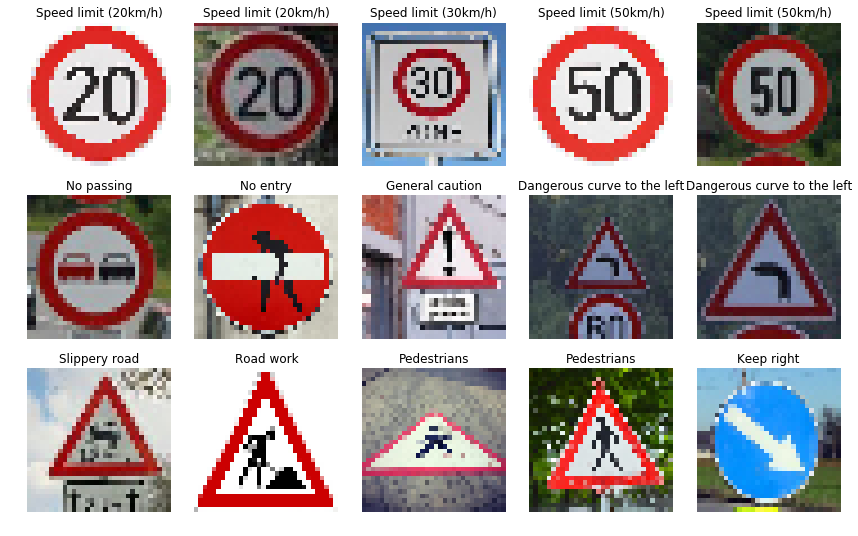

In [20]:
pic_dir = "test_images"
import os
pic_path = os.listdir(pic_dir)
pic_label = [0, 0, 1, 2, 2, 9, 17, 18, 19, 19, 23, 25, 27, 27, 38]
assert len(pic_path)==len(pic_label), "Available images and labels have different lengths"
#print(pic_path)

pics = []
for img_id in range(len(pic_label)):
    pics.append(plt.imread(os.path.join(pic_dir,pic_path[img_id])))
    pics[-1] = cv2.resize(pics[-1], (32,32))

# Plot up to 15 test images
fig, axs = plt.subplots(3,5, figsize=(15, 9))
fig.subplots_adjust(hspace = .2, wspace=.001)
axs = axs.ravel()
for i in range(len(pics)):
    axs[i].set_title('{}'.format(signname_label(pic_label[i])))
    axs[i].axis('off')
    axs[i].imshow(pics[i])

### Predict the Sign Type for Each Image

In [21]:
X_new = pics

y_new = pic_label
X_new = preprocessing(X_new)
X_new = X_new.reshape(-1,32,32,1)

pred = tf.nn.softmax(logits)
with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('.'))
    
    predictions = sess.run(pred, feed_dict={x: X_new, keep_prob: 1.})
    top_pred = sess.run(tf.nn.top_k(tf.constant(predictions), k=5))
    #print(top_pred)

INFO:tensorflow:Restoring parameters from .\convnet


### Visualization of the Softmax probabilites of every image

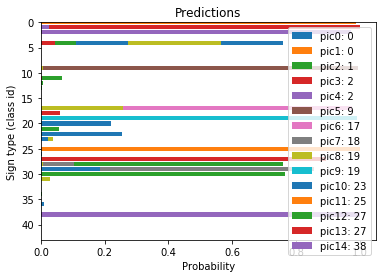

In [22]:
label_id = np.arange(0,n_classes,1)[::-1]
plt.figure()
plt.title("Predictions")
for pic_id in range(len(predictions)):
    plt.barh(label_id, predictions[pic_id][::-1], label='pic{}: {}'.format(pic_id, pic_label[pic_id]))
plt.ylabel('Sign type (class id)')
plt.xlabel('Probability')
plt.ylim(n_classes,0)
plt.legend()

### Analyze Performance

In [23]:
true_pred = 0
for img_id in range(len(pic_label)):
    pred_tmp = top_pred[1][img_id][0]#signnames['SignName'].values[top_pred[1][img_id][0]]
    if pred_tmp == pic_label[img_id]:
        true_pred += 1
    val = 100*top_pred[0][img_id][0]
    
    #print('Image {} : {}'.format(img_id, pic_label[img_id]))#signnames['SignName'].values[pic_label[img_id]] ))
    #print('Predicted {} with {:.1f} % certainty'.format(pred_tmp, val))

accuracy = true_pred/len(pic_label)
print('The test images were classified with {:.2f} accuracy'.format(accuracy))

The test images were classified with 0.53 accuracy


### Output Top 5 Softmax Probabilities For Each Image Found on the Web

In [ ]:
for img_id in range(len(pics)):
    result = ('True: {}\n'.format(signname(img_id, y_data=pic_label)) +
            '{:.1f}% {}\n'.format(100*top_pred[0][img_id][0], signname_label(top_pred[1][img_id][0])) +
            '{:.1f}% {}\n'.format(100*top_pred[0][img_id][1], signname_label(top_pred[1][img_id][1])) +
            '{:.1f}% {}\n'.format(100*top_pred[0][img_id][2], signname_label(top_pred[1][img_id][2])) +
            '{:.1f}% {}\n'.format(100*top_pred[0][img_id][3], signname_label(top_pred[1][img_id][3])) +
            '{:.1f}% {}\n'.format(100*top_pred[0][img_id][4], signname_label(top_pred[1][img_id][4])) )
    print(result)

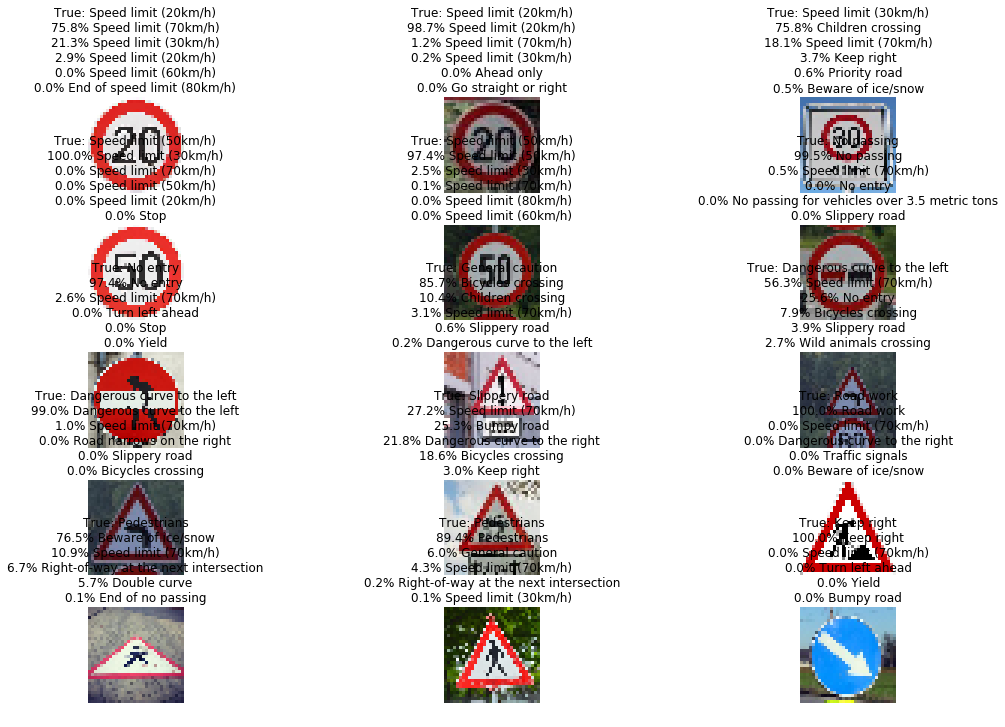

In [28]:
# Visualize top 5 probabilities for every image
fig, axs = plt.subplots(5,3, figsize=(15, 9))
#plt.subplots_adjust(bottom=0.05, left=0.05, right=0.95, top=0.5, hspace=0.5, wspace=0.01)
fig.tight_layout()
#fig.subplots_adjust(hspace=5, wspace=.05)
axs = axs.ravel()
for img_id in range(len(pics)):
    result = ('True: {}\n'.format(signname(img_id, y_data=pic_label)) +
            '{:.1f}% {}\n'.format(100*top_pred[0][img_id][0], signname_label(top_pred[1][img_id][0])) +
            '{:.1f}% {}\n'.format(100*top_pred[0][img_id][1], signname_label(top_pred[1][img_id][1])) +
            '{:.1f}% {}\n'.format(100*top_pred[0][img_id][2], signname_label(top_pred[1][img_id][2])) +
            '{:.1f}% {}\n'.format(100*top_pred[0][img_id][3], signname_label(top_pred[1][img_id][3])) +
            '{:.1f}% {}'.format(100*top_pred[0][img_id][4], signname_label(top_pred[1][img_id][4])) )
    axs[img_id].set_title(result)
    #axs[img_id].text(2, 0, 'extra text')
    axs[img_id].axis('off')
    axs[img_id].imshow(pics[img_id])


### Project Writeup

Once you have completed the code implementation, document your results in a project writeup using this [template](https://github.com/udacity/CarND-Traffic-Sign-Classifier-Project/blob/master/writeup_template.md) as a guide. The writeup can be in a markdown or pdf file. 

> **Note**: Once you have completed all of the code implementations and successfully answered each question above, you may finalize your work by exporting the iPython Notebook as an HTML document. You can do this by using the menu above and navigating to  \n",
    "**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.

True: Speed limit (20km/h)
75.8% Speed limit (70km/h)
21.3% Speed limit (30km/h)
2.9% Speed limit (20km/h)
0.0% Speed limit (60km/h)
0.0% End of speed limit (80km/h)

True: Speed limit (20km/h)
98.7% Speed limit (20km/h)
1.2% Speed limit (70km/h)
0.2% Speed limit (30km/h)
0.0% Ahead only
0.0% Go straight or right

True: Speed limit (30km/h)
75.8% Children crossing
18.1% Speed limit (70km/h)
3.7% Keep right
0.6% Priority road
0.5% Beware of ice/snow

True: Speed limit (50km/h)
100.0% Speed limit (30km/h)
0.0% Speed limit (70km/h)
0.0% Speed limit (50km/h)
0.0% Speed limit (20km/h)
0.0% Stop

True: Speed limit (50km/h)
97.4% Speed limit (50km/h)
2.5% Speed limit (30km/h)
0.1% Speed limit (70km/h)
0.0% Speed limit (80km/h)
0.0% Speed limit (60km/h)

True: No passing
99.5% No passing
0.5% Speed limit (70km/h)
0.0% No entry
0.0% No passing for vehicles over 3.5 metric tons
0.0% Slippery road

True: No entry
97.4% No entry
2.6% Speed limit (70km/h)
0.0% Turn left ahead
0.0% Stop
0.0% Yield

